# [Project] 가위바위보 분류기

### 1. 모듈 Import 

In [1]:
from PIL import Image
import os, glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

print("[PIL Import Success.]")

[PIL Import Success.]


### 2. 경로 설정

In [2]:
train_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train"  # 학습 이미지 셋(Train Set)
test_img_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test" # 테스트 이미지 셋(Test Set)

### 3. 데이터 전처리 ( Train Set )
#### 1) Imgs Resize

In [3]:
target_size = (28,28) # 28*28 사이즈 설정
dirs = ['/rock/', '/scissor/', '/paper/']

def resize_image(img): # imgs open, resize, save
    old_img = Image.open(img)
    new_img = old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")

for dir in dirs: # 각 폴더 경로 지정
    images = glob.glob(train_img_path + dir + "*.jpg")
    for img in images:
        resize_image(img)

print("[Train Set Resize Success.]")

[Train Set Resize Success.]


#### 2) 데이터 로드 ( Train & Test Set )
* Reshape Imgs, Labels

In [4]:
def load_data(img_path, num):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data = num # 가위바위보 이미지 개수 총합
    img_size = 28
    color = 3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터 이미지 개수는",idx,"입니다.")
    return imgs, labels

#### 3) 0~1 사이의 값으로 정규화

In [5]:
(x_train, y_train) = load_data(train_img_path, 4286)
x_train_norm = x_train / 255.0   # 각 픽셀의 값이 0~255 사이 범위에 있으므로, 데이터들을 255.0 으로 나눔

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

데이터 이미지 개수는 4286 입니다.
x_train shape: (4286, 28, 28, 3)
y_train shape: (4286,)


#### 4) 이미지 테스트

라벨:  0
[[ 71  90  96]
 [ 62  81  85]
 [100 115 118]
 [ 57  68  70]
 [  6  11  14]
 [150 152 151]
 [167 166 164]
 [165 160 157]
 [159 151 148]
 [140 135 129]
 [ 98  95  88]
 [ 78  78  70]
 [ 98 101  92]
 [107 112 105]
 [100 107  99]
 [102 112 103]
 [109 106  97]
 [109 106  97]
 [109 106  97]
 [109 106  97]
 [109 106  97]
 [110 107  98]
 [111 108  99]
 [112 109 100]
 [132 129 120]
 [139 136 127]
 [137 134 125]
 [128 125 116]]


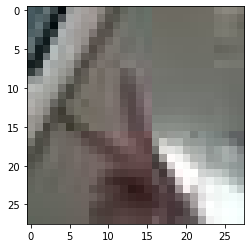

In [6]:
n = 5
plt.imshow(x_train[n])
print('라벨: ', y_train[n])
print(x_train[n][0])

### 4. 딥러닝 네트워크 설계

In [7]:
n_channel_1 = 32 # 얼마나 다양한 이미지의 특징을 살펴볼 것인가
n_channel_2 = 64 # 입력 이미지가 다양할 수록 더 많은 특징을 고려
#n_channel_3 = 64 # 입력 이미지가 다양할 수록 더 많은 특징을 고려
n_dense = 64 # 분류기 알고리즘을 얼마나 복잡하게 할 것인가
n_epoch = 10 # 전체 데이터를 n 만큼 반복 학습

tf.random.set_seed(1)  # 동일한 결과를 보장하기 위한 seed 고정
model=keras.models.Sequential()  # Sequential 모델
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (No

### 5. 데이터 학습

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_norm, y_train, epochs=n_epoch)

Epoch 1/10
134/134 [==============================] - 6s 19ms/step - loss: 1.0559 - accuracy: 0.4225
Epoch 2/10
134/134 [==============================] - 0s 3ms/step - loss: 0.5804 - accuracy: 0.7630
Epoch 3/10
134/134 [==============================] - 0s 3ms/step - loss: 0.3210 - accuracy: 0.8858
Epoch 4/10
134/134 [==============================] - 0s 3ms/step - loss: 0.2152 - accuracy: 0.9256
Epoch 5/10
134/134 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.9679
Epoch 6/10
134/134 [==============================] - 0s 3ms/step - loss: 0.0743 - accuracy: 0.9852
Epoch 7/10
134/134 [==============================] - 0s 3ms/step - loss: 0.0453 - accuracy: 0.9923
Epoch 8/10
134/134 [==============================] - 0s 3ms/step - loss: 0.0407 - accuracy: 0.9935
Epoch 9/10
134/134 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9975
Epoch 10/10
134/134 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.997

### 6. 데이터 전처리 ( Test Set )
#### 1) Imgs Resize

In [9]:
target_size = (28,28) # 28*28 사이즈 설정
dirs = ['/rock/', '/scissor/', '/paper/']

def resize_image(img): # imgs open, resize, save
    old_img = Image.open(img)
    new_img = old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")

for dir in dirs: # 각 폴더 경로 지정
    images = glob.glob(test_img_path + dir + "*.jpg")
    for img in images:
        resize_image(img)

print("[Test Set Resize Success.]")

[Test Set Resize Success.]


#### 2) 0~1 사이의 값으로 정규화

In [16]:
(x_test, y_test) = load_data(test_img_path, 300)
x_test_norm = x_test / 255.0   # 각 픽셀의 값이 0~255 사이 범위에 있으므로, 데이터들을 255.0 으로 나눔

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

데이터 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


#### 3) 데이터 테스트

라벨:  0
[[127 135 156]
 [126 134 155]
 [127 132 154]
 [131 133 156]
 [139 137 159]
 [146 141 163]
 [152 144 165]
 [154 145 166]
 [155 146 165]
 [157 150 166]
 [156 152 166]
 [154 152 163]
 [153 156 165]
 [157 164 170]
 [159 168 173]
 [158 167 172]
 [172 163 164]
 [179 173 175]
 [168 166 169]
 [172 173 177]
 [171 178 184]
 [168 181 187]
 [175 192 200]
 [162 184 195]
 [113 137 149]
 [ 97 123 136]
 [100 126 139]
 [110 136 149]]


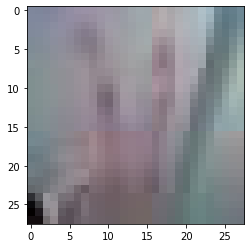

In [14]:
n = 5
plt.imshow(x_test[n])
print('라벨: ', y_test[n])
print(x_test[n][0])

#### 4) 모델 테스트

In [15]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 1s - loss: 0.6845 - accuracy: 0.7067
test_loss: 0.6845130324363708 
test_accuracy: 0.7066666483879089


# 모델 개선 방법 및 결과

1. 모델 개선 방법
    * 하이퍼 파라미터를 조정하며 최적의 loss, accurcay 값을 찾아갔다
2. 결과
    * loss : 1.3592 -> 0.6845
    * accuracy : 0.2421 -> 0.7067